In [1]:
import os
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import cv2
import glob
import re
import string
import numpy as np
import pandas as pd 
from tqdm import tqdm
from PIL import Image
import tensorflow.keras
import tensorflow as tf
from skimage import measure 
import matplotlib.pyplot as plt
from keras.models import Model
from sklearn import preprocessing
import matplotlib.patches as mpatches 
from tensorflow.keras import layers
from keras import backend as K
import matplotlib.patches as patches
from keras.callbacks import CSVLogger
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import Sequential
#bounding boxes with filtering
import numpy as np
from PIL import Image
from tensorflow.keras.metrics import Precision, Recall
from cellpose import models
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2, l1
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from skimage.measure import label, regionprops, regionprops_table
from tensorflow.keras import Sequential, models, regularizers, layers, optimizers, losses, metrics
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, Conv1D, MaxPooling1D
from tensorflow.keras.applications import ResNet50, MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from tensorflow.keras.layers import Dense, InputLayer, Dropout, Flatten, BatchNormalization, Activation, Input, Add, GlobalAveragePooling2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Flatten, Dense, GlobalAveragePooling2D, MaxPooling2D, AveragePooling2D
from tensorflow.python.compiler.tensorrt import trt_convert as trt
from tensorflow.keras.applications.resnet import preprocess_input
from multiprocessing import Pool


In [2]:
# Import necessary libraries
import tensorflow as tf

# Get the list of available physical GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
# If you have two GPUs, you might want to use both
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

        # Use the first two GPUs
        tf.config.experimental.set_visible_devices(gpus[:2], 'GPU')
    except RuntimeError as e:
        print(e)


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [3]:
# define the file paths for the plate annotations, images and corresponding masks
plate_annot = '/4tbint/Plate_annotations_newMoAs_pooled_d2d3d4/'
plate_path = '/4tbint/Corrected Merged FOVs/Pooled_wells_d2d3d4/'
mask_path = '/4tbint/Cellpose Masks/Pooled_wells_d2d3d4/'

#use the glob library to generate lists of image and mask filenames
annotations = sorted([os.path.basename(x) for x in glob.glob(plate_annot+ '/*')])
plates =  sorted([os.path.basename(x) for x in glob.glob(plate_path+ '/*')])
masks = sorted([os.path.basename(x) for x in glob.glob(mask_path+ '/*')])


# When training for DMSO vs treatments (based on cell count range)

In [4]:
image_name_w_paths = [[]]
mask_name_w_paths = []
y_label = []
j=0

for i in range(len(annotations)):
    
    annotation_file = os.path.join(plate_annot, annotations[i])
    annot_file = pd.read_excel(annotation_file)
    labels = ['DMSO', 'Drug']
    annot_file = annot_file.loc[annot_file['Label'].isin(labels)]
    #MoA_category = ['EGFR', 'VEGFR', 'PI3K', 'Topoisomerase', 'Mitotic', 'MEK1/2', 'PARP', 'CDK', 'BET', 'HDAC', 'Negative Controls', 'Negative Controls ']
    #MoA_category = ['EGFR','Negative Controls', 'Negative Controls ']
    #ann = annot_file.loc[annot_file['Category'].isin(MoA_category)]
    #ann = ann.loc[ann["MoA"] != 'cells' ]
    #selected_df = ann[(ann['Cancer_Count'] > 1100) & (ann['Cancer_Count'] < 1930) | (ann['Label'] == 'DMSO')]
    selected_df = annot_file
    
    print(selected_df)
    def well_to_image(well_number):
        row = string.ascii_uppercase.index(well_number[0])+1

        col = int(well_number[1:])

        image_name = f'r{row:02d}c{col:02d}'

        return image_name

    selected_df['Image'] = selected_df['Well_number'].apply(well_to_image)
    
    names = selected_df['Image'].to_list()
    
    image_file = os.path.join(plate_path, plates[i])
    
    mask_file = os.path.join(mask_path, masks[i])

    imgs = sorted([os.path.basename(x) for x in glob.glob(image_file+ '/*.tiff')])

    msks = sorted([os.path.basename(x) for x in glob.glob(mask_file+ '/*.tiff')])
    
    for img in range(0, len(imgs), 3):
        imagename_ch1 = imgs[img]
        imagename_ch2 = imgs[img+1]
        imagename_ch4 = imgs[img+2]
        
        prefix_im = imagename_ch1.split('ch')[0]
        
        if prefix_im in names:
            
            im_ch1 = os.path.join(image_file, imagename_ch1)
            im_ch2 = os.path.join(image_file, imagename_ch2)
            im_ch4 = os.path.join(image_file, imagename_ch4)
            
            image_name_w_paths[j].append(im_ch1)
            image_name_w_paths[j].append(im_ch2)
            image_name_w_paths[j].append(im_ch4)
            image_name_w_paths.append([])
            
            cat = selected_df.loc[selected_df['Image'] == prefix_im, 'Label'].values[0]
            
            y_label.append(cat)   
            
            j=j+1
            
    for maskname in msks:
        prefix_msk = maskname.split('ch')[0]
        if prefix_msk in names:
            msk = os.path.join(mask_file, maskname)
            mask_name_w_paths.append(msk)
                           
image_names_w_paths = list(filter(None, image_name_w_paths))
X = image_names_w_paths    
X_cellpose = mask_name_w_paths
Y = y_label
label_encoder = preprocessing.LabelEncoder()
Y_Y = label_encoder.fit_transform(Y)

   Well_number     Compound  \
0           B3   Vorinostat   
1          C13  Ixabepilone   
2          H20   Epirubicin   
3          J15     Eribulin   
4           M6    Rucaparib   
5          M12   Romidepsin   
6          M14    Topotecan   
7           N6    Rucaparib   
8           N7         DMSO   
9          N12   Romidepsin   
10         N14    Topotecan   
11          O2     Olaparib   
12          O7  Vincristine   
13          P3         DMSO   

                                                  MoA  Concentration Label  \
0                                      HDAC inhibitor           1000  Drug   
1   Mitotic inhibitor. Epothilone microtubule stab...             10  Drug   
2                          Topoisomerase II inhibitor            100  Drug   
3       Mitotic inhibitor, microtubule depolymerizer.              1  Drug   
4                                      PARP inhibitor             10  Drug   
5                                      HDAC inhibitor             

In [5]:
print(len(X))
print(len(X_cellpose))
print(len(Y_Y))



131
131
131


In [6]:
ch1 = []
ch2 = []
ch4 = []
for i in range(len(X)):
    image_paths = X[i]
    image_ch1 = Image.open(image_paths[0])
    image_ch2 = Image.open(image_paths[1])
    image_ch4 = Image.open(image_paths[2])
    ch1.append(np.array(image_ch1))
    ch2.append(np.array(image_ch2))
    ch4.append(np.array(image_ch4))
    
ch1_max = np.max(ch1)
ch2_max = np.max(ch2)
ch4_max = np.max(ch4)
print("Maximum intensity for channel 1:", ch1_max)
print("Maximum intensity for channel 2:", ch2_max)
print("Maximum intensity for channel 4:", ch4_max)

ch1_q099 =  np.quantile(ch1, 0.99)
ch2_q099 =  np.quantile(ch2, 0.99)
ch4_q099 =  np.quantile(ch4, 0.99)
print("Quantile_099 channel 1:", ch1_q099)
print("Quantile_099 channel 2:", ch2_q099)
print("Quantile_099 channel 4:", ch4_q099)

Maximum intensity for channel 1: 65162
Maximum intensity for channel 2: 65535
Maximum intensity for channel 4: 65295
Quantile_099 channel 1: 7039.0
Quantile_099 channel 2: 4019.0
Quantile_099 channel 4: 5971.0


In [7]:
def data_generator(X, Y, batch_size):

    while True:
        single_cell_bbox = []
        single_cell_bbox_label = []
        for i in range(batch_size):
            image_paths = X[i]
            image_ch1 = Image.open(image_paths[0])
            image_ch2 = Image.open(image_paths[1])
            image_ch4 = Image.open(image_paths[2])
            cellpose_img = Image.open(X_cellpose[i])

            image_array_ch1 = np.array(image_ch1)
            image_array_ch2 = np.array(image_ch2)
            image_array_ch4 = np.array(image_ch4)
            masks_ch2 = np.array(cellpose_img)

            labels_ch2 = label(masks_ch2)

            props = regionprops(labels_ch2)

            for cell_label, target_region in enumerate(props, start=1):
                centroid_row, centroid_col = target_region.centroid

                half_size = 25
                min_row = int(max(centroid_row - half_size, 0))
                max_row = int(min(centroid_row + half_size, image_array_ch2.shape[0]))
                min_col = int(max(centroid_col - half_size, 0))
                max_col = int(min(centroid_col + half_size, image_array_ch2.shape[1]))

                if (min_row > 0 and max_row < image_array_ch2.shape[0] and 
                min_col > 0 and max_col < image_array_ch2.shape[1]):

                    target_cell_mask = labels_ch2 == cell_label

                    cell_area_original = np.where(target_cell_mask[min_row:max_row, min_col:max_col], image_array_ch2[min_row:max_row, min_col:max_col], 0)

                    empty_array_ch2 = np.zeros((50, 50))
                    paste_row_original = (50 - cell_area_original.shape[0]) // 2
                    paste_col_original = (50 - cell_area_original.shape[1]) // 2

                    empty_array_ch2[paste_row_original:paste_row_original+cell_area_original.shape[0], paste_col_original:paste_col_original+cell_area_original.shape[1]] = cell_area_original

                    empty_array_cellpose = np.zeros((50, 50))
                    cell_area_cellpose = target_cell_mask[min_row:max_row, min_col:max_col]

                    paste_row_cellpose = (50 - cell_area_cellpose.shape[0]) // 2
                    paste_col_cellpose = (50 - cell_area_cellpose.shape[1]) // 2

                    empty_array_cellpose[paste_row_cellpose:paste_row_cellpose+cell_area_cellpose.shape[0], paste_col_cellpose:paste_col_cellpose+cell_area_cellpose.shape[1]] = cell_area_cellpose

                    cell_area_ch1 = np.where(target_cell_mask[min_row:max_row, min_col:max_col], image_array_ch1[min_row:max_row, min_col:max_col], 0)
                    cell_area_ch4 = np.where(target_cell_mask[min_row:max_row, min_col:max_col], image_array_ch4[min_row:max_row, min_col:max_col], 0)

                    empty_array_ch1 = np.zeros((50, 50))
                    paste_row_ch1 = (50 - cell_area_ch1.shape[0]) // 2
                    paste_col_ch1 = (50 - cell_area_ch1.shape[1]) // 2

                    empty_array_ch4 = np.zeros((50, 50))
                    paste_row_ch4 = (50 - cell_area_ch4.shape[0]) // 2
                    paste_col_ch4 = (50 - cell_area_ch4.shape[1]) // 2

                    empty_array_ch1[paste_row_ch1:paste_row_ch1+cell_area_ch1.shape[0], paste_col_ch1:paste_col_ch1+cell_area_ch1.shape[1]] = cell_area_ch1
                    empty_array_ch4[paste_row_ch4:paste_row_ch4+cell_area_ch4.shape[0], paste_col_ch4:paste_col_ch4+cell_area_ch4.shape[1]] = cell_area_ch4
                    '''
                    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(10, 5))
                    ax1.imshow(empty_array_cellpose, cmap='gray')
                    ax1.set_title(f'Cellpose Cell {cell_label}')
                    ax2.imshow(empty_array_ch2, cmap='gray')
                    ax2.set_title(f'Channel 2 Cell {cell_label}')
                    ax3.imshow(empty_array_ch1, cmap='gray')
                    ax3.set_title(f'Channel 1 Cell {cell_label}')
                    ax4.imshow(empty_array_ch4, cmap='gray')
                    ax4.set_title(f'Channel 4 Cell {cell_label}')
                    plt.show()
                    '''
                    empty_array_ch1 = (empty_array_ch1.astype('float32')/ch1_q099)*255
                    
                    empty_array_ch2 = (empty_array_ch2.astype('float32')/ch2_q099)*255

                    empty_array_ch4 = (empty_array_ch4.astype('float32')/ch4_q099)*255
                    #print(np.min(empty_array_ch4))
                    
                    singlecell = np.stack((empty_array_ch1, empty_array_ch2, empty_array_ch4), axis=-1)
                            
                    reshaped_singlecell = singlecell.reshape((50,50,3))
                    single_cell_bbox.append(reshaped_singlecell)
                    single_cell_bbox_label.append(Y_Y[i])

        #print(f'Image shape: {(np.asarray(single_cell_bbox)).shape}')
        #print(f'Label: {(np.asarray(single_cell_bbox_label)).shape}')
        yield np.asarray(single_cell_bbox), np.asarray(single_cell_bbox_label)


In [8]:
X_train, X_val, X_cellpose_train, X_cellpose_val, Y_train, Y_val = train_test_split(X, X_cellpose, Y_Y, test_size=0.3, random_state=42)

print("The length of training dataset: {}".format(len(X_train)))
print("The length of training cellpose dataset: {}".format(len(X_cellpose_train)))
print("The length of training label dataset: {}".format(len(Y_train)))
print("The length of validation dataset: {}".format(len(X_val)))
print("The length of validation cellpose dataset: {}".format(len(X_cellpose_val)))
print("The length of validation label dataset: {}".format(len(Y_val)))



The length of training dataset: 91
The length of training cellpose dataset: 91
The length of training label dataset: 91
The length of validation dataset: 40
The length of validation cellpose dataset: 40
The length of validation label dataset: 40


In [9]:
input_shape=(50, 50, 3)

conv_base = ResNet50(weights='imagenet',include_top=False,input_shape=input_shape)

print(conv_base.summary())

for layer in conv_base.layers:
    layer.trainable = False
print('Last block of the conv_base is not trainable')

'''
for layer in conv_base.layers[81:]:
    layer.trainable = True
print('Last block of the conv_base is not trainable')
'''

for i, layer in enumerate(conv_base.layers):
   print(i, layer.name, layer.trainable)

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50, 50, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 56, 56, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 25, 25, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 25, 25, 64)   256         ['conv1_conv[0][0]']             
                                                                                           

                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 13, 13, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 13, 13, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_3_conv (Conv2D)   (None, 13, 13, 256)  16640       ['conv2_block3_2_relu[0][0]']    
                                                                                                  
 conv2_block3_3_bn (BatchNormal  (None, 13, 13, 256)  1024       ['conv2_block3_3_conv[0][0]']    
 ization) 

                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 7, 7, 128)   512         ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 7, 7, 128)   0           ['conv3_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_3_conv (Conv2D)   (None, 7, 7, 512)    66048       ['conv3_block3_2_relu[0][0]']    
                                                                                                  
 conv3_block3_3_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv3_block3_3_conv[0][0]']    
 ization) 

                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 4, 4, 256)   1024        ['conv4_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_2_relu (Activatio  (None, 4, 4, 256)   0           ['conv4_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_3_conv (Conv2D)   (None, 4, 4, 1024)   263168      ['conv4_block2_2_relu[0][0]']    
                                                                                                  
 conv4_block2_3_bn (BatchNormal  (None, 4, 4, 1024)  4096        ['conv4_block2_3_conv[0][0]']    
 ization) 

 n)                                                                                               
                                                                                                  
 conv4_block5_3_conv (Conv2D)   (None, 4, 4, 1024)   263168      ['conv4_block5_2_relu[0][0]']    
                                                                                                  
 conv4_block5_3_bn (BatchNormal  (None, 4, 4, 1024)  4096        ['conv4_block5_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_add (Add)         (None, 4, 4, 1024)   0           ['conv4_block4_out[0][0]',       
                                                                  'conv4_block5_3_bn[0][0]']      
                                                                                                  
 conv4_blo

 n)                                                                                               
                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 2, 2, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_3_bn (BatchNormal  (None, 2, 2, 2048)  8192        ['conv5_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_add (Add)         (None, 2, 2, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_bn[0][0]']      
                                                                                                  
 conv5_blo

In [10]:
num_classes = 1

model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(1024, activation='relu'))#, kernel_regularizer=l1(0.01)))
model.add(Dropout(0.1))
model.add(layers.Dense(512, activation='sigmoid'))#, kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(layers.Dense(num_classes, activation='sigmoid')) 
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                          

In [11]:
batch_size = 1
train_generator = data_generator(X_train, Y_train, batch_size)
val_generator = data_generator(X_val, Y_val, batch_size)

# Compile the model (you may need to adjust the loss and optimizer based on your task)
OPT = tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(optimizer=OPT, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model using the generator
history = model.fit(train_generator, steps_per_epoch=len(X_train)//batch_size, epochs=40,
          verbose=1, validation_data=val_generator, validation_steps=len(X_val)//batch_size)
 


Epoch 1/40
91/91 [==============================] - 408s 4s/step - loss: 0.7609 - accuracy: 0.5315 - val_loss: 0.8188 - val_accuracy: 0.0975
Epoch 2/40
91/91 [==============================] - 403s 4s/step - loss: 0.6734 - accuracy: 0.6110 - val_loss: 0.6733 - val_accuracy: 0.5589
Epoch 3/40
91/91 [==============================] - 403s 4s/step - loss: 0.6083 - accuracy: 0.6845 - val_loss: 0.5800 - val_accuracy: 0.8697
Epoch 4/40
91/91 [==============================] - 403s 4s/step - loss: 0.5535 - accuracy: 0.7554 - val_loss: 0.5198 - val_accuracy: 0.9131
Epoch 5/40
91/91 [==============================] - 402s 4s/step - loss: 0.5063 - accuracy: 0.8149 - val_loss: 0.4671 - val_accuracy: 0.9373
Epoch 6/40
91/91 [==============================] - 404s 4s/step - loss: 0.4648 - accuracy: 0.8629 - val_loss: 0.4286 - val_accuracy: 0.9566
Epoch 7/40
91/91 [==============================] - 401s 4s/step - loss: 0.4287 - accuracy: 0.8989 - val_loss: 0.3970 - val_accuracy: 0.9739
Epoch 8/40
91

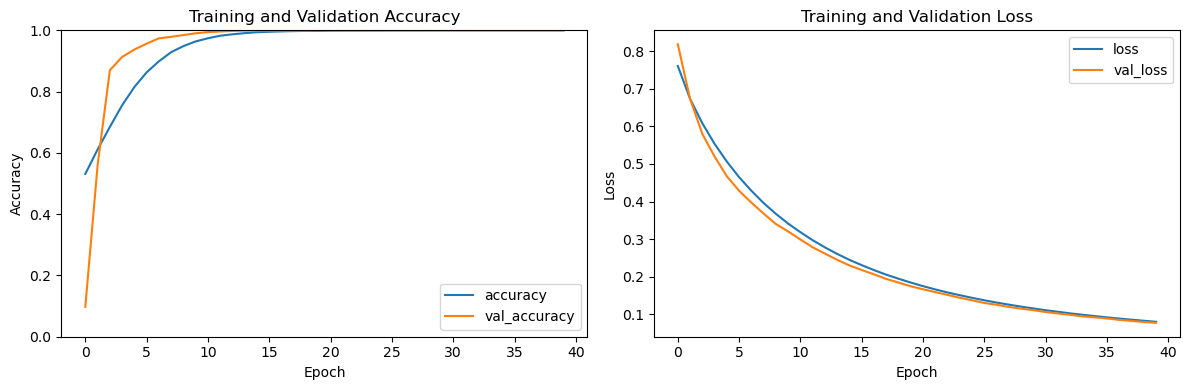

In [12]:
# Save training history to CSV
history_df = pd.DataFrame(history.history)
history_df.to_csv('/home/gauss/Desktop/Training_ONLYTOPCLASSIFICATION_pooled_wells_d2d3d4/training_history.csv', index=False)

# Plot accuracy and loss curves
plt.figure(figsize=(12, 4))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig("/home/gauss/Desktop/Training_ONLYTOPCLASSIFICATION_pooled_wells_d2d3d4/Acc_Loss.png")


plt.tight_layout()
plt.show()

In [13]:
model.save("/home/gauss/Desktop/Training_ONLYTOPCLASSIFICATION_pooled_wells_d2d3d4/Trained_Model")


2024-01-01 20:21:36.861220: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /home/gauss/Desktop/Training_ONLYTOPCLASSIFICATION_pooled_wells_d2d3d4/Trained_Model/assets


In [ ]:
'''
single_cell_bbox= []
single_cell_bbox_label = []
for i in range(len(X_train)):
    print(i)
    image_paths = X_train[i]
    image_ch1 = Image.open(image_paths[0])
    image_ch2 = Image.open(image_paths[1])
    image_ch4 = Image.open(image_paths[2])
    cellpose_img = Image.open(X_cellpose_train[i])

    image_array_ch1 = np.array(image_ch1)
    image_array_ch2 = np.array(image_ch2)
    image_array_ch4 = np.array(image_ch4)
    masks_ch2 = np.array(cellpose_img)

    labels_ch2 = label(masks_ch2)

    props = regionprops(labels_ch2)

    for cell_label, target_region in enumerate(props, start=1):
        centroid_row, centroid_col = target_region.centroid

        half_size = 25
        min_row = int(max(centroid_row - half_size, 0))
        max_row = int(min(centroid_row + half_size, image_array_ch2.shape[0]))
        min_col = int(max(centroid_col - half_size, 0))
        max_col = int(min(centroid_col + half_size, image_array_ch2.shape[1]))

        if (min_row > 0 and max_row < image_array_ch2.shape[0] and 
        min_col > 0 and max_col < image_array_ch2.shape[1]):

            target_cell_mask = labels_ch2 == cell_label

            cell_area_original = np.where(target_cell_mask[min_row:max_row, min_col:max_col], image_array_ch2[min_row:max_row, min_col:max_col], 0)
            
            empty_array_ch2 = np.zeros((50, 50))
            paste_row_original = (50 - cell_area_original.shape[0]) // 2
            paste_col_original = (50 - cell_area_original.shape[1]) // 2

            empty_array_ch2[paste_row_original:paste_row_original+cell_area_original.shape[0], paste_col_original:paste_col_original+cell_area_original.shape[1]] = cell_area_original

            empty_array_cellpose = np.zeros((50, 50))
            cell_area_cellpose = target_cell_mask[min_row:max_row, min_col:max_col]

            paste_row_cellpose = (50 - cell_area_cellpose.shape[0]) // 2
            paste_col_cellpose = (50 - cell_area_cellpose.shape[1]) // 2

            empty_array_cellpose[paste_row_cellpose:paste_row_cellpose+cell_area_cellpose.shape[0], paste_col_cellpose:paste_col_cellpose+cell_area_cellpose.shape[1]] = cell_area_cellpose

            cell_area_ch1 = np.where(target_cell_mask[min_row:max_row, min_col:max_col], image_array_ch1[min_row:max_row, min_col:max_col], 0)
            cell_area_ch4 = np.where(target_cell_mask[min_row:max_row, min_col:max_col], image_array_ch4[min_row:max_row, min_col:max_col], 0)

            empty_array_ch1 = np.zeros((50, 50))
            paste_row_ch1 = (50 - cell_area_ch1.shape[0]) // 2
            paste_col_ch1 = (50 - cell_area_ch1.shape[1]) // 2

            empty_array_ch4 = np.zeros((50, 50))
            paste_row_ch4 = (50 - cell_area_ch4.shape[0]) // 2
            paste_col_ch4 = (50 - cell_area_ch4.shape[1]) // 2

            empty_array_ch1[paste_row_ch1:paste_row_ch1+cell_area_ch1.shape[0], paste_col_ch1:paste_col_ch1+cell_area_ch1.shape[1]] = cell_area_ch1
            empty_array_ch4[paste_row_ch4:paste_row_ch4+cell_area_ch4.shape[0], paste_col_ch4:paste_col_ch4+cell_area_ch4.shape[1]] = cell_area_ch4
            '''
            fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(10, 5))
            ax1.imshow(empty_array_cellpose, cmap='gray')
            ax1.set_title(f'Cellpose Cell {cell_label}')
            ax2.imshow(empty_array_ch2, cmap='gray')
            ax2.set_title(f'Channel 2 Cell {cell_label}')
            ax3.imshow(empty_array_ch1, cmap='gray')
            ax3.set_title(f'Channel 1 Cell {cell_label}')
            ax4.imshow(empty_array_ch4, cmap='gray')
            ax4.set_title(f'Channel 4 Cell {cell_label}')
            plt.show()
            '''
            empty_array_ch1 = (empty_array_ch1.astype('float32')/ch1_max)
            empty_array_ch2 = (empty_array_ch2.astype('float32')/ch2_max)
            empty_array_ch4 = (empty_array_ch4.astype('float32')/ch4_max)
            
            singlecell = np.stack((empty_array_ch4, empty_array_ch1, empty_array_ch2), axis=-1)
            reshaped_singlecell = singlecell.reshape((50,50,3))
            single_cell_bbox.append(reshaped_singlecell)
            single_cell_bbox_label.append(Y_train[i])

x_t = np.asarray(single_cell_bbox)
y_t = np.asarray(single_cell_bbox_label)
'''

'''
single_cell_bbox= []
single_cell_bbox_label = []
for i in range(len(X_val)):
    print(i)
    image_paths = X_val[i]
    image_ch1 = Image.open(image_paths[0])
    image_ch2 = Image.open(image_paths[1])
    image_ch4 = Image.open(image_paths[2])
    cellpose_img = Image.open(X_cellpose_val[i])

    image_array_ch1 = np.array(image_ch1)
    image_array_ch2 = np.array(image_ch2)
    image_array_ch4 = np.array(image_ch4)
    masks_ch2 = np.array(cellpose_img)

    labels_ch2 = label(masks_ch2)

    props = regionprops(labels_ch2)

    for cell_label, target_region in enumerate(props, start=1):
        centroid_row, centroid_col = target_region.centroid

        half_size = 25
        min_row = int(max(centroid_row - half_size, 0))
        max_row = int(min(centroid_row + half_size, image_array_ch2.shape[0]))
        min_col = int(max(centroid_col - half_size, 0))
        max_col = int(min(centroid_col + half_size, image_array_ch2.shape[1]))

        if (min_row > 0 and max_row < image_array_ch2.shape[0] and 
        min_col > 0 and max_col < image_array_ch2.shape[1]):

            target_cell_mask = labels_ch2 == cell_label

            cell_area_original = np.where(target_cell_mask[min_row:max_row, min_col:max_col], image_array_ch2[min_row:max_row, min_col:max_col], 0)
            
            empty_array_ch2 = np.zeros((50, 50))
            paste_row_original = (50 - cell_area_original.shape[0]) // 2
            paste_col_original = (50 - cell_area_original.shape[1]) // 2

            empty_array_ch2[paste_row_original:paste_row_original+cell_area_original.shape[0], paste_col_original:paste_col_original+cell_area_original.shape[1]] = cell_area_original

            empty_array_cellpose = np.zeros((50, 50))
            cell_area_cellpose = target_cell_mask[min_row:max_row, min_col:max_col]

            paste_row_cellpose = (50 - cell_area_cellpose.shape[0]) // 2
            paste_col_cellpose = (50 - cell_area_cellpose.shape[1]) // 2

            empty_array_cellpose[paste_row_cellpose:paste_row_cellpose+cell_area_cellpose.shape[0], paste_col_cellpose:paste_col_cellpose+cell_area_cellpose.shape[1]] = cell_area_cellpose

            cell_area_ch1 = np.where(target_cell_mask[min_row:max_row, min_col:max_col], image_array_ch1[min_row:max_row, min_col:max_col], 0)
            cell_area_ch4 = np.where(target_cell_mask[min_row:max_row, min_col:max_col], image_array_ch4[min_row:max_row, min_col:max_col], 0)

            empty_array_ch1 = np.zeros((50, 50))
            paste_row_ch1 = (50 - cell_area_ch1.shape[0]) // 2
            paste_col_ch1 = (50 - cell_area_ch1.shape[1]) // 2

            empty_array_ch4 = np.zeros((50, 50))
            paste_row_ch4 = (50 - cell_area_ch4.shape[0]) // 2
            paste_col_ch4 = (50 - cell_area_ch4.shape[1]) // 2

            empty_array_ch1[paste_row_ch1:paste_row_ch1+cell_area_ch1.shape[0], paste_col_ch1:paste_col_ch1+cell_area_ch1.shape[1]] = cell_area_ch1
            empty_array_ch4[paste_row_ch4:paste_row_ch4+cell_area_ch4.shape[0], paste_col_ch4:paste_col_ch4+cell_area_ch4.shape[1]] = cell_area_ch4
            
            
            empty_array_ch1 = (empty_array_ch1.astype('float32')/ch1_max)
            empty_array_ch2 = (empty_array_ch2.astype('float32')/ch2_max)
            empty_array_ch4 = (empty_array_ch4.astype('float32')/ch4_max)
            
            singlecell = np.stack((empty_array_ch4,empty_array_ch1, empty_array_ch2), axis=-1)
            reshaped_singlecell = singlecell.reshape((50,50,3))
            single_cell_bbox.append(reshaped_singlecell)
            single_cell_bbox_label.append(Y_val[i])

x_v = np.asarray(single_cell_bbox)
y_v = np.asarray(single_cell_bbox_label)
'''

'''
print(x_t.shape)
print(y_t.shape)
print(x_v.shape)
print(y_v.shape)
from collections import Counter
print(Counter(Y_Y))
'''

'''
# Convert to TensorFlow tensors
x_t_tensor = tf.convert_to_tensor(x_t, dtype=tf.float32)
y_t_tensor = tf.convert_to_tensor(y_t, dtype=tf.int32)
x_v_tensor = tf.convert_to_tensor(x_v, dtype=tf.float32)
y_v_tensor = tf.convert_to_tensor(y_v, dtype=tf.int32)
'''